### Can we look at units where a preferred feature explains some amount of variance in certain conditions?
- Look at when a feature is chosen, correct, and then chosen, incorrect. 
- conditions: time, preferred, time/preferred. 

In [24]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import SESS_SPIKES_PATH, TrialInterval, UNITS_PATH
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy
import itertools
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
from utils.anova_utils import anova_factors, cal_unit_var

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def load_data(sess_name, feat, trial_interval, response, subject="SA", unit_id=None):
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, sess_name)
    beh = behavioral_utils.get_chosen_single(feat, beh)
    beh = beh[beh.PreferredChosen]

    beh = beh[(beh.Response == response) & (beh.Choice == feat)]
    beh["FeatPreferred"] = beh["PreferredBelief"].apply(lambda x: "Preferred" if x == feat else "Not Preferred")
    num_pref = len(beh[beh.FeatPreferred == "Preferred"])
    num_not_pref = len(beh[beh.FeatPreferred == "Not Preferred"])

    spikes_path = SESS_SPIKES_PATH.format(
        sub=subject,
        sess_name=sess_name, 
        fr_type="firing_rates",
        pre_interval=trial_interval.pre_interval, 
        event=trial_interval.event, 
        post_interval=trial_interval.post_interval, 
        interval_size=trial_interval.interval_size
    )
    frs = pd.read_pickle(spikes_path)
    frs["PseudoUnitID"] = int(sess_name) * 100 + frs.UnitID.astype(int)
    frs = frs[frs.TimeBins < 1.8]
    if unit_id is not None:
        frs = frs[frs.PseudoUnitID == unit_id]
    df = pd.merge(frs, beh, on="TrialNumber")
    return df, num_pref, num_not_pref

def process_session(row, feat, interval, response):
    data, _, _ = load_data(row.session_name, feat, interval, response)
    df = anova_factors(data, ["TimeBins", "FeatPreferred"])
    unit_vars = df.groupby("PseudoUnitID").apply(lambda x: cal_unit_var(x, ["TimeBins", "FeatPreferred"])).reset_index()
    return unit_vars

In [17]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
feat = "RIPPLE"
response = "Correct"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)
row = feat_sessions[feat_sessions.feat == feat].iloc[0]
sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
interval = TrialInterval("FeedbackOnset", 1800, 1500, 100)

### Look at correct responses, chose feature

In [18]:
tqdm.pandas()
all_res = []
for feat in FEATURES:
    row = feat_sessions[feat_sessions.feat == feat].iloc[0]
    sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
    res = pd.concat(sessions.progress_apply(lambda x: process_session(x, feat, interval, response), axis=1).values)
    res["interaction_frac"] = res.x_FeatPreferred_fracvar + res.x_TimeBinsFeatPreferred_fracvar
    res["feat"] = feat
    all_res.append(res)
all_res = pd.concat(all_res)

  0%|          | 0/22 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/22 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/15 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/11 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/21 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/25 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: 

  0%|          | 0/17 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: 

  0%|          | 0/16 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/13 [00:00<?, ?it/s]

In [19]:
all_res

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,interaction_frac,feat
0,2018070900,0.805217,0.032063,1.023922e-03,0.003789,0.963124,1.0,0.004813,CIRCLE
1,2018070901,0.450355,0.008770,4.625774e-04,0.002573,0.988194,1.0,0.003036,CIRCLE
2,2018070902,2.699705,0.005906,8.882368e-07,0.002370,0.991724,1.0,0.002371,CIRCLE
3,2018070903,5.397490,0.009192,2.639139e-03,0.005171,0.982998,1.0,0.007811,CIRCLE
4,2018070904,5.588726,0.002590,3.164907e-02,0.003096,0.962665,1.0,0.034745,CIRCLE
...,...,...,...,...,...,...,...,...,...
22,2018081722,4.473785,0.011962,3.327919e-03,0.002656,0.982054,1.0,0.005984,SWIRL
23,2018081723,17.619157,0.047035,1.891759e-04,0.003643,0.949133,1.0,0.003832,SWIRL
24,2018081724,1.268976,0.011686,5.521919e-04,0.007562,0.980200,1.0,0.008114,SWIRL
25,2018081725,0.425986,0.003475,9.931256e-05,0.009937,0.986489,1.0,0.010036,SWIRL


In [20]:
units = all_res.sort_values(by="interaction_frac", ascending=False)[:10]

In [21]:
units

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,interaction_frac,feat
6,2018092606,3.825643,0.006308,0.108231,0.010226,0.875235,1.0,0.118457,TRIANGLE
5,2018091205,36.260022,0.069439,0.094757,0.008493,0.827311,1.0,0.103250,CYAN
21,2018091921,219.655863,0.038970,0.083282,0.017243,0.860505,1.0,0.100525,STAR
12,2018090712,150.673772,0.024727,0.083003,0.002499,0.889771,1.0,0.085502,SQUARE
7,2018091907,3.598973,0.005577,0.077427,0.006932,0.910063,1.0,0.084360,GREEN
8,2018081308,33.912142,0.017002,0.073960,0.002409,0.906629,1.0,0.076369,YELLOW
17,2018083017,51.645493,0.003193,0.069877,0.005402,0.921527,1.0,0.075279,GREEN
14,2018082114,36.953831,0.204528,0.055066,0.017954,0.722452,1.0,0.073020,STAR
12,2018062212,86.006953,0.014033,0.064160,0.008162,0.913645,1.0,0.072321,MAGENTA
34,2018080334,62.730290,0.017007,0.064678,0.001605,0.916709,1.0,0.066284,CIRCLE


In [25]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))

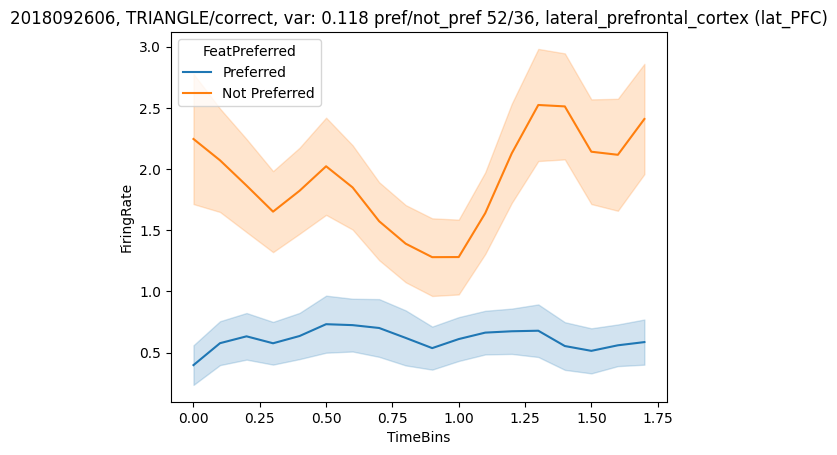

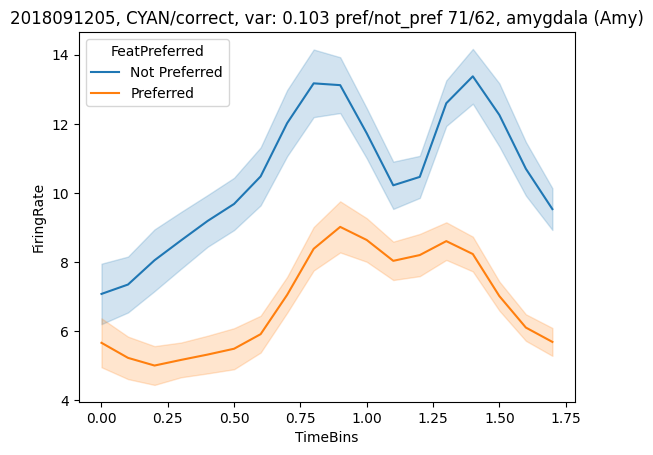

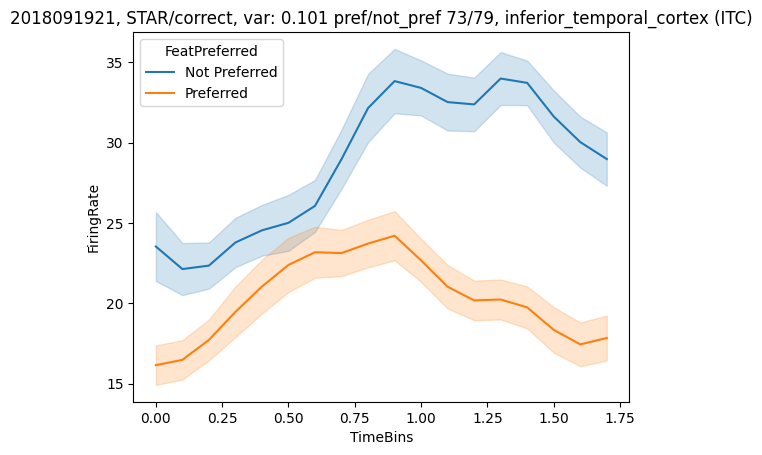

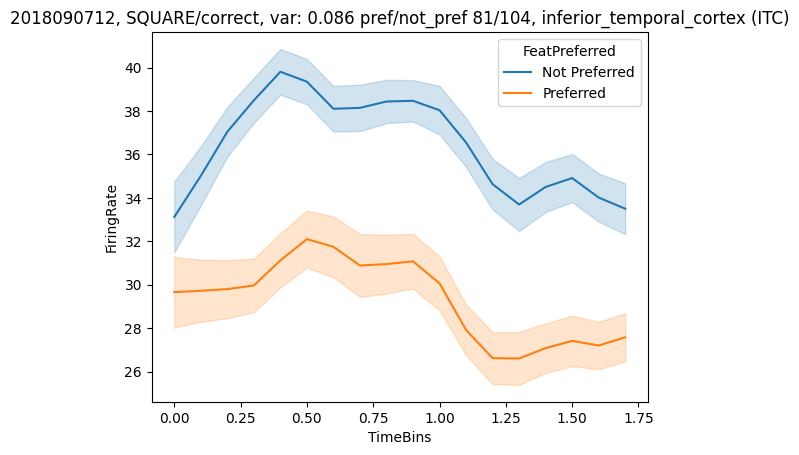

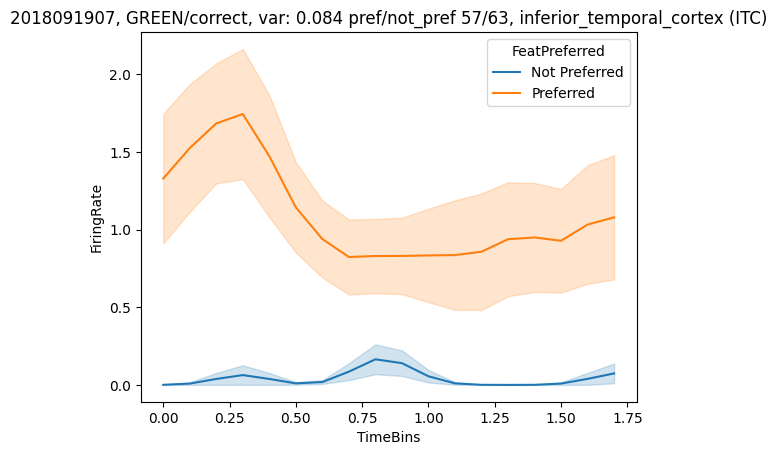

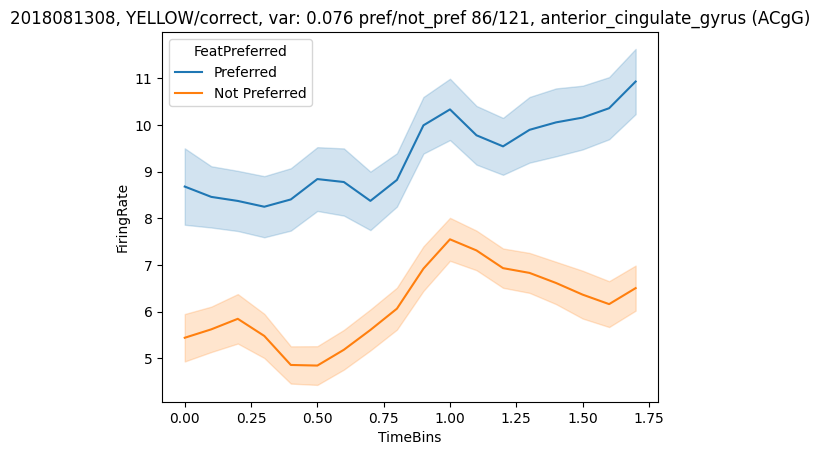

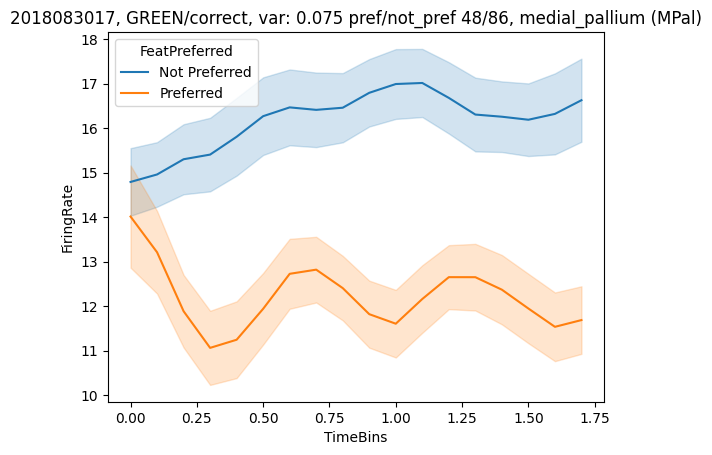

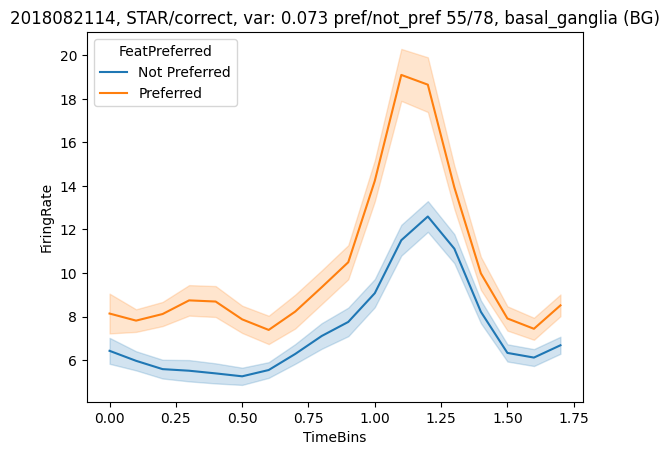

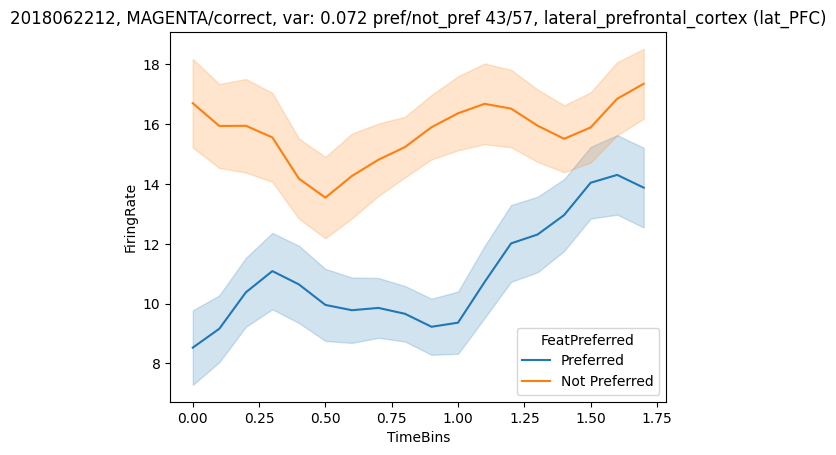

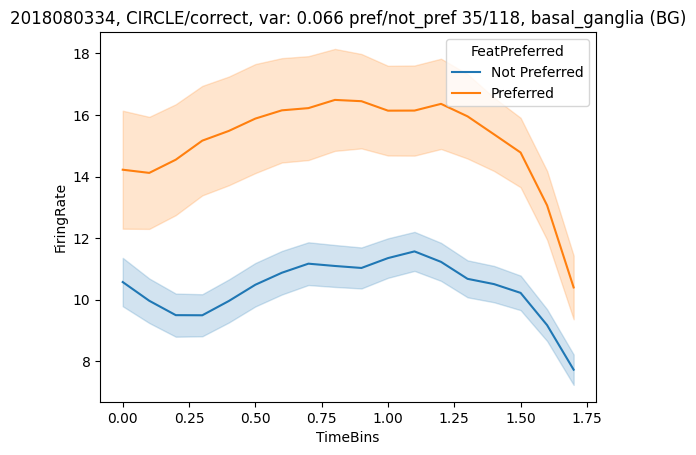

In [30]:
for i, unit in units.iterrows():
    unit_id = int(unit.PseudoUnitID)
    unit_frs, num_pref, num_not_pref = load_data(int(unit_id / 100), unit.feat, interval, response, unit_id=unit_id)
    pos = unit_pos[unit_pos.PseudoUnitID == unit_id].iloc[0].structure_level2

    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, ax = plt.subplots()
    sns.lineplot(unit_frs, x="TimeBins", y="FiringRate", hue="FeatPreferred", errorbar="se", ax=ax)
    ax.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.interaction_frac:.3f} pref/not_pref {num_pref}/{num_not_pref}, {pos}")